In [2]:
import sys
import os

# Add the path to your ML directory
sys.path.append(r'C:\Users\admin\Documents\Masters\ES_Masters\Masters-Processing\ML')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from mrmr_wrapper import MRMRTransformer
import optuna
import optuna.visualization as vis
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve, average_precision_score)

# Import and Prepare Data

In [2]:
# Load the data
file_path = "features-Master.csv"
data = pd.read_csv(file_path)

# Shuffle the data
shuffled = data.sample(frac=1, random_state=42).reset_index(drop=True)
data_shuffled = shuffled.iloc[:, 4:]
labels_shuffled = shuffled["Comfort Score"]

# Create binary labels (1,2 = 0; 4,5 = 1; exclude 3 for clearer separation)
binary_labels = labels_shuffled.apply(lambda x: 0 if x <= 2 else (1 if x >=4 else np.nan))
binary_data = data_shuffled[~binary_labels.isna()]
binary_labels = binary_labels[~binary_labels.isna()] # The "~" operator is used to filter out NaN values (i.e., rows where Comfort Score == 3)

Number of Comfort Score == 3: 100


# Train/Test Split

In [3]:
# For binary classification
X_train, X_test, y_train, y_test = train_test_split(
    binary_data,
    binary_labels,
    test_size=0.2,
    stratify=binary_labels,
    random_state=42
)

# Optimize Feature Selection and RF Parameters

In [ ]:
X = X_train.copy()
y = y_train.copy()

def binary_classification_objective(trial):
    # Feature selection, only optimizing method and number of features (no hyperparameters of the methods)
    fs_method = trial.suggest_categorical('feature_selection', ['MRMR', 'RFE', 'None'])
    
    if fs_method != 'None':
        k_features = trial.suggest_int('k_features', 5, 105, step = 10) # Only allow a maximum of 105 features to be selected, with a step of 10, to go up to all features: X.shape[1]
        if fs_method == 'RFE':
            estimator = RandomForestClassifier()
            selector = RFE(estimator, n_features_to_select=k_features)
        else: #MRMR
            selector = MRMRTransformer(k_features=k_features) #https://feature-engine.trainindata.com/en/1.8.x/api_doc/selection/MRMR.html#feature_engine.selection.MRMR
    else:
        selector = 'passthrough'
    
    # RF Hyperparameters
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=50),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss']),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'random_state': 42
    }
    model = RandomForestClassifier(**params)

    # Pipeline
    pipeline = Pipeline([
        ('feature_selection', selector),
        ('model', model)
    ])

    # Cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    try:
        scores = cross_val_score(pipeline, X, y, cv=cv, scoring='roc_auc', n_jobs=1)
        return np.mean(scores)
    except Exception as e:
        print(f"Error in trial: {e}")
        return -np.inf

# Run binary classification study
study = optuna.create_study(direction='maximize')
study.optimize(binary_classification_objective, n_trials=5, show_progress_bar=True)

# Print results
print("\nBinary Classification Optimization Results:")
print(f"Best Accuracy Score: {study.best_value:.4f}")
print("Best Parameters:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

[I 2025-09-02 10:53:15,067] A new study created in memory with name: no-name-7c849b01-906a-4731-ae48-5622001ef43a


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2025-09-02 10:57:05,960] Trial 0 finished with value: 0.778980278980279 and parameters: {'feature_selection': 'RFE', 'k_features': 105, 'n_estimators': 800, 'max_depth': 10, 'criterion': 'gini', 'min_samples_split': 10, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.778980278980279.


100%|██████████| 95/95 [00:03<00:00, 28.39it/s]


Got MRMR features


100%|██████████| 95/95 [00:03<00:00, 28.29it/s]


Got MRMR features


100%|██████████| 95/95 [00:03<00:00, 27.68it/s]


Got MRMR features


100%|██████████| 95/95 [00:03<00:00, 27.99it/s]


Got MRMR features


100%|██████████| 95/95 [00:03<00:00, 28.12it/s]


Got MRMR features
[I 2025-09-02 10:57:31,268] Trial 1 finished with value: 0.7744070744070743 and parameters: {'feature_selection': 'MRMR', 'k_features': 95, 'n_estimators': 400, 'max_depth': 16, 'criterion': 'entropy', 'min_samples_split': 12, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.778980278980279.
[I 2025-09-02 11:01:33,429] Trial 2 finished with value: 0.7803418803418805 and parameters: {'feature_selection': 'RFE', 'k_features': 85, 'n_estimators': 400, 'max_depth': 11, 'criterion': 'gini', 'min_samples_split': 17, 'min_samples_leaf': 10}. Best is trial 2 with value: 0.7803418803418805.


100%|██████████| 5/5 [00:00<00:00, 33.54it/s]


Got MRMR features


100%|██████████| 5/5 [00:00<00:00, 34.05it/s]


Got MRMR features


100%|██████████| 5/5 [00:00<00:00, 34.36it/s]


Got MRMR features


100%|██████████| 5/5 [00:00<00:00, 34.15it/s]


Got MRMR features


100%|██████████| 5/5 [00:00<00:00, 28.75it/s]


Got MRMR features
[I 2025-09-02 11:01:38,620] Trial 3 finished with value: 0.7401505901505901 and parameters: {'feature_selection': 'MRMR', 'k_features': 5, 'n_estimators': 750, 'max_depth': 17, 'criterion': 'gini', 'min_samples_split': 2, 'min_samples_leaf': 7}. Best is trial 2 with value: 0.7803418803418805.


100%|██████████| 95/95 [00:03<00:00, 28.30it/s]


Got MRMR features


100%|██████████| 95/95 [00:03<00:00, 28.57it/s]


Got MRMR features


100%|██████████| 95/95 [00:03<00:00, 28.68it/s]


Got MRMR features


100%|██████████| 95/95 [00:03<00:00, 27.52it/s]


Got MRMR features


100%|██████████| 95/95 [00:03<00:00, 28.06it/s]


Got MRMR features
[I 2025-09-02 11:02:01,345] Trial 4 finished with value: 0.7737016070349404 and parameters: {'feature_selection': 'MRMR', 'k_features': 95, 'n_estimators': 700, 'max_depth': 8, 'criterion': 'log_loss', 'min_samples_split': 13, 'min_samples_leaf': 7}. Best is trial 2 with value: 0.7803418803418805.

Binary Classification Optimization Results:
Best Accuracy Score: 0.7803
Best Parameters:
  feature_selection: RFE
  k_features: 85
  n_estimators: 400
  max_depth: 11
  criterion: gini
  min_samples_split: 17
  min_samples_leaf: 10


# Visualization

In [ ]:
# 1. Parameter Importance Plot
fig = vis.plot_param_importances(study, target_name="ROC AUC Score")
fig.show()

# 2. Slice Plot (Best for seeing individual parameter effects)
fig = vis.plot_slice(
    study,
    params=['max_depth', 'n_estimators', 'criterion', 'k_features'],
    target_name="ROC AUC Score"
)
fig.show()

# Apply Feature Selection to Training and Test Data

In [ ]:
# apply feature selection code from before
best_fs_method = study.best_params.get('feature_selection', 'None')

if best_fs_method != 'None':
    k_features = study.best_params['k_features']
    if best_fs_method == 'RFE':
        estimator = RandomForestClassifier()
        selector = RFE(estimator)
    elif best_fs_method == 'MRMR':
        selector = MRMRTransformer(k_features=k_features)
    
    selector.fit(X, y)
    if hasattr(selector, 'get_support'):  # For RFE
        selected_features = X.columns[selector.get_support()]
    else:  # For MRMR
        selected_features = selector.selected_features
    X_best = X[selected_features]
else:
    X_best = X
    selected_features = X.columns

# Apply the same feature selection to test data
if best_fs_method != 'None':
    if best_fs_method == 'MRMR':
        X_test_final = X_test[selected_features]
    else:
        X_test_final = selector.transform(X_test)  # Use the already fitted selector
        if isinstance(X_test, pd.DataFrame):
            X_test_final = pd.DataFrame(X_test_final, columns=selected_features)
else:
    X_test_final = X_test

# Create RF Model with Optimized Parameters and Fit Model

In [15]:
best_model = RandomForestClassifier(
    n_estimators=study.best_params['n_estimators'],
    max_depth=study.best_params['max_depth'],
    criterion=study.best_params['criterion'],
    min_samples_split=study.best_params['min_samples_split'],
    min_samples_leaf=study.best_params['min_samples_leaf'],
    random_state=42
)

# Train on full imputed data
best_model.fit(X_best, y)

# Save best parameters in a dictionary
params_dict = {}
for param, value in study.best_params.items():
    params_dict.update({param: value})
    
print(params_dict)

feature_selection: RFE
k_features: 85
n_estimators: 400
max_depth: 11
criterion: gini
min_samples_split: 17
min_samples_leaf: 10
{'feature_selection': 'RFE', 'k_features': 85, 'n_estimators': 400, 'max_depth': 11, 'criterion': 'gini', 'min_samples_split': 17, 'min_samples_leaf': 10}


# Run Model and Get Outcomes


Final Model Evaluation on Test Set:
Accuracy: 0.7167
Precision: 0.7222
Recall: 0.7879
F1 Score: 0.7536
ROC AUC: 0.7239


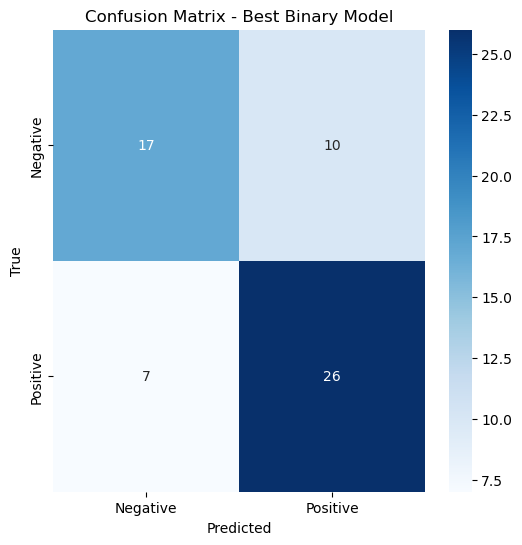

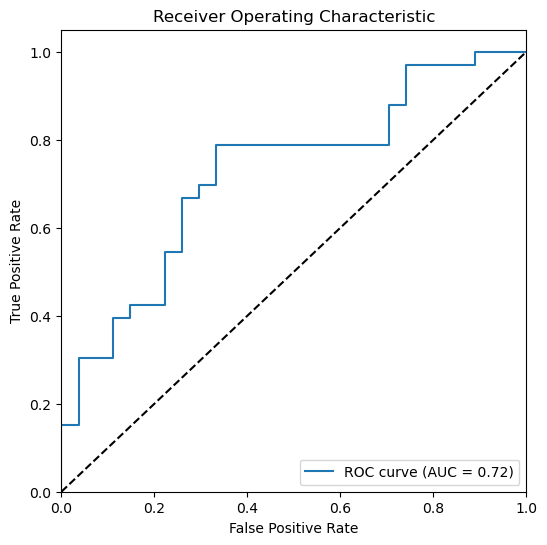

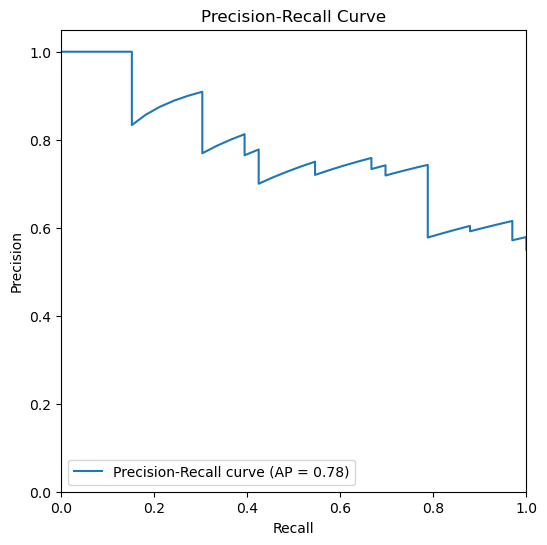

In [11]:
# Make predictions
y_pred = best_model.predict(X_test_final)
y_pred_proba = best_model.predict_proba(X_test_final)[:, 1]  # Probabilities for class 1

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("\nFinal Model Evaluation on Test Set:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix - Best Binary Model')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba)
average_precision = average_precision_score(y_test, y_pred_proba)
plt.figure(figsize=(6,6))
plt.plot(recall_curve, precision_curve, label=f'Precision-Recall curve (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()